# Manual Review of Promising Candidates

Here we list out a bunch of candidates and teir parameters which have promising weirdness in their ligghtcurves...
We'll add that to our talk... once the data is cumulated

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit
import aliensims as dy
from ellc import lc
from transit import occultnonlin, occultquad

### List of candidates
<ol>
    <li>KIC 8110757: potential eclipsing binary but highly assymetric curve
    <li>KIC 5357901 (KOI 188b, Kepler-425): tidally fluctuating hot jupiter
    <li>KIC 5358624: tidally fluctuating hot jupiter
    <li>KIC 9651668: tidally fluctuating hot jupiter
    <li>KIC 5596440: heartbeat
    <li>KIC 11805075: personal curiosity - seems like normal transit
    <li>KIC 5215508: seems to be two flare events
    <li>KIC 9941662: seemsto be contact binary signatures
    <li>KIC 6372268: contact binary signatures
    <li>KIC 9025971: seems to be some tiny mid transit flares... could just be noise
    <li>KIC 8308347: personal curiosity
    <li>KIC 10975146: assymetric like 1
    <li>KIC 11449844: one flare dot mid transit - probably false alarm
</ol>

In [2]:
#Directory setting for candidate list
#FILEPATH_FPS="E:\Masters_Project_Data\\alienworlds_fps\\"
FILEPATH_FPS="/media/ushasi/Elements/Masters_Project_Data/alienworlds_fps/"
k1 = 'kplr008110757-20160128150956_dvt.fits'
k2 = 'kplr005357901-20160128150956_dvt.fits'
k3 = 'kplr005358624-20160128150956_dvt.fits'
k4 = 'kplr009651668-20160128150956_dvt.fits'
k5 = 'kplr005596440-20160128150956_dvt.fits'
k6 = 'kplr011805075-20160128150956_dvt.fits'
k7 = 'kplr005215508-20160128150956_dvt.fits'
k8 = 'kplr009941662-20160128150956_dvt.fits'
k9 = 'kplr006372268-20160128150956_dvt.fits'
k10= 'kplr009025971-20160128150956_dvt.fits'
k11= 'kplr008308347-20160128150956_dvt.fits'
k12= 'kplr010975146-20160128150956_dvt.fits'
k13= 'kplr011449844-20160128150956_dvt.fits'



### Model fitting functions
Here are routines needed for fitting the models if and when...

In [6]:
#algol model:
def pl(z,p):

    if(1+p <z):
        return(0)

    elif(1-p<z and z<1+p):
        k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
        k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
        y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
        return(y)

    elif(z<1-p):
        return(p**2)

    elif(z<p-1):
        return(1)


def new_plar(ph,p,u1,u2,rorb,imp):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2+imp**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def ldtest(ph,p,rorb, imp):
    # p = 0.113
    # rorb = 11.6
    # imp = 0.602
    incl = np.arccos(imp/rorb)*180/np.pi
    #print(incl)
    a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[0.5967,0.1914],
        shape_1='sphere', shape_2='sphere')
    return(a -1) 

def new_plar_v2(ph,p,u1,u2,rorb, imp, e, w):
    incl = np.arccos(imp/rorb)*180/np.pi
    a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[u1,u2],
        shape_1='sphere', shape_2='sphere',f_c=np.sqrt(e)*np.cos(w),f_s=np.sqrt(e)*np.sin(w))
    return(a -1) 
    

def plar(ph,p,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    op =[]
    for z in znp:
        if(1+p <z):
            op.append(0)

        elif(1-p<z and z<1+p):
            k0 = np.arccos((p**2 + z**2 - 1)/(2*p*z))
            k1 = np.arccos(( -p**2 + z**2 + 1)/(2*z))
            y = (1/np.pi)*(p**2*k0 + k1 - np.sqrt((4*z**2 - (1+z**2 -p**2)**2)/4))
            op.append(y)

        elif(z<1-p):
            op.append(p**2)

        elif(z<p-1):
            op.append(1)
    return(-np.array(op))

    #else: return(0)

Opening file and header:

In [13]:
hdu = fits.open(FILEPATH_FPS+k3)
print("number of TCEs:", len(hdu)-2)

flux = []
flux_white=[]
phase = []
model = []
tp = hdu[1].header['TPERIOD']
for ph, fl,wl, ml in zip(hdu[1].data['PHASE'],hdu[1].data['LC_DETREND'],hdu[1].data['LC_WHITE'],hdu[1].data['MODEL_WHITE']):
    if not np.isnan(fl):
        flux.append(fl)
        phase.append(ph/tp)
        flux_white.append(wl)
        model.append(ml)
dfunb = pd.DataFrame(list(zip(phase, flux, flux_white, model)),columns=['phase', 'flux','flux_white', 'model'])
df=dfunb.sort_values('phase',axis=0,ascending=True)
bins=np.linspace(min(df['phase']),max(df['phase']),8000)
groups = df.groupby(np.digitize(df['phase'], bins))
df=groups.median()
print('size:',len(df))
#print(hdu[0].header)

number of TCEs: 1
size: 8000


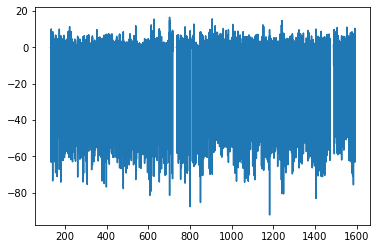

In [5]:
plt.plot(hdu[1].data['TIME'],hdu[1].data['MODEL_WHITE'])
# plt.plot(hdu[2].data['TIME'],hdu[2].data['MODEL_WHITE'])
# plt.plot(hdu[3].data['TIME'],hdu[3].data['MODEL_WHITE'])
#plt.plot(hdu[1].data['PHASE']*10)
#plt.xlim(600,620)
#plt.ylim(-20,20)
#print(hdu[1].header['TDUR'],hdu[2].header['TDUR'],hdu[3].header['TDUR'],hdu[1].header['TPERIOD'],hdu[2].header['TPERIOD'],hdu[3].header['TPERIOD'],)

### Limb Darkening Statistics
<table>
<tr>
    <td>KIC</td>
    <td>Rpl
    <td>Rorb
    <td>u1
    <td>u2
    <td>b
    <td>e
</tr>
<tr>
    <td>KIC 8110757</td>
    <td>0.31774 (0.037)
    <td>1.528 (3.5193)
    <td>0.3975 
    <td>0.2650
    <td>1.262 (34.34 deg)
    <td>0
</tr>
<tr>
    <td>KIC 5357901</td>
    <td>0.108759
    <td>13.635
    <td>0.5256
    <td>0.1860
    <td>0.602 (88.65 deg)
    <td>0
</tr>
<tr>
    <td>KIC 5358624</td>
    <td>0.13372
    <td>11.699
    <td>0.5167
    <td>0.1914
    <td>0.12 (89.41 deg)
    <td>0
</tr>
<tr>
    <td>KIC 9651668</td>
    <td>0.121923
    <td>8.546
    <td>0.4415
    <td>0.2396
    <td>0.076 (89.49 deg)
    <td>0
</tr>
<tr>
    <td>KIC 5596440</td>
    <td>0.04377
    <td>1.346
    <td>0.2913
    <td>0.3120
    <td>0.972 (43.72 deg)
    <td>0
</tr>
<tr>
    <td>KIC 6372268</td>
    <td>0.04,0.03,0.002
    <td>24.4,17.7,51.52
    <td>1,-0.29,0.5 (-.1)
    <td>0,1,0
    <td>0
    <td>0
</tr>
</table>

In [18]:

# popt2, pcov2 = curve_fit(new_plar, np.array(df['phase']), np.array(df['flux']), 
#     bounds=([0.037,0.4974,0.2650,1], [1,0.4975,0.2651,40]))

popt3, pcov3 = curve_fit(ldtest, np.array(df['phase']), np.array(df['flux']),p0=[0.13,11.699,0.01], 
    bounds=([0.0001,3,0], [0.2,15,2]))

# popte2, pcove2 = curve_fit(new_plar, np.array(df['phase'])-0.043, np.array(df['flux']), 
#     bounds=([0.004,-1,-1,1.00001], [0.7,1.1,1,30]))

# popte, pcove = curve_fit(new_plar, np.array(df['phase'])[40000:]-0.555, np.array(df['flux'])[40000:], 
#     bounds=([0.0,0,0,1.00001], [0.7,1.1,1,100]))

# popte2, pcove2 = curve_fit(new_plar, np.array(df['phase'])[40000:]-0.555, np.array(df['flux'])[40000:], 
#    bounds=([0.0,0,0,1.00001], [0.7,1,1,100]))

In [19]:
# print("Params:",np.round(popt3,2), np.round(popte2,2), np.round(popte,2))
print("Var",np.trace(pcov3))
print("Params:",np.round(popt3,4))
print("Var",np.trace(pcov3))
# print(np.array(df['phase'][63789]),np.array(df['phase'][0]))

Var 0.0003243187103455522
Params: [0.1446 8.5916 0.6755]
Var 0.0003243187103455522


In [20]:
from scipy.signal import find_peaks,lombscargle
kernel = np.ones(20)/20
nf = np.convolve((df['flux']),kernel, mode='same')

plp, _ = find_peaks(-nf, height=0.0005, distance=400)
peakf = nf[plp]
print([el for el in zip(df['phase'][plp],peakf)])

[(0.0003582485734972798, -0.022261680010706185)]


old 0.0001553340491523278 new: 0.00026757184025700517


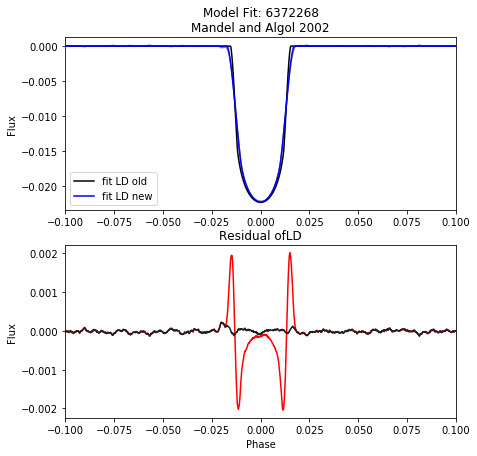

In [23]:
fig, ax = plt.subplots(2,1,figsize=(7,7))
exp = ldtest(np.array(df['phase']), *popt3)
exp2 = new_plar_v2(np.array(df['phase']), 0.1337, 0.5167, 0.1914, 11.699, 0.012, 0,0)
#exp2 = new_plar(np.array(df['phase']), 0.0374, 0.3975, 0.2650, 6,0.2)

# expe = new_plar(np.array(df['phase'])-0.555, *popte)
# expe2 = new_plar(np.array(df['phase'])-0.043, *popte2)


# props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
# txt = "$R_{pl}$/$R_{st}$:"+str(np.round(popt2[0],4))+"\nu1:"+str(np.round(popt2[1]-.1,4
#     ))+"\nu2:"+str(np.round(popt2[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(popt2[3]/2,4))


# ax[1].text(0.80, 0.5, txt, fontsize=11,transform=ax[1].transAxes,  horizontalalignment='center',
#             verticalalignment='center', linespacing=2, bbox=props, color='white')
ax[0].set_title('Model Fit: 6372268\nMandel and Algol 2002')
#ax[0].scatter(np.array(df['phase'])[plp],nf[plp], zorder=2)
ax[0].plot(np.array(df['phase']),nf, color='gray', zorder=1)
ax[0].plot(np.array(df['phase']), exp2, color='black', label='fit LD old')
ax[0].plot(np.array(df['phase']), exp, color='blue', label='fit LD new')
# ax[0].plot(np.array(df['phase']), exp2+expe+expe2, color='red', label='fit LD')
ax[1].set_title('Residual ofLD')
ax[1].set_xlabel('Phase')
ax[0].set_ylabel('Flux')
ax[0].legend()
ax[1].set_ylabel('Flux')
# ax[0].set_ylim(-0.0022,0.002)
# ax[1].set_ylim(-0.0015,0.001)
# ax[2].set_ylim(-0.0015,0.001)
ax[0].set_xlim(-0.1,0.1)
ax[1].set_xlim(-0.1,0.1)
#ax[2].set_xlim(-0.2,0.2)

ax[1].plot(np.array(df['phase']),np.convolve(exp2- df['flux'], kernel, mode='same'), color='red')
ax[1].plot(np.array(df['phase']),np.convolve(exp- df['flux'], kernel, mode='same'), color='#222222')

print('old',np.std(exp- df['flux']), 'new:',np.std(exp2- df['flux']))
#plt.savefig("not_tides_5359701.png")


In [133]:
bins=np.linspace(min(df['phase']),max(df['phase']),4000)
#dfop = pd.DataFrame(zip(df['phase'], df['flux'],new_plar(np.array(df['phase']), *popt2)), columns=['phase','flux', 'model'])

dfop = pd.DataFrame(zip(df['phase'], nf,exp2), columns=['phase','flux', 'model'])
#dfop = pd.DataFrame(zip(df['phase'], nf,exp), columns=['phase','flux', 'model'])
groups = dfop.groupby(np.digitize(df['phase'], bins))
dfop=groups.median()
dfop.to_csv('fprez_6372268.csv', sep=',', index=False)

### Trying out a 2D simulation...

In [69]:
nflux=[x for x,y in zip(df['flux'],df['phase']) if(y<0.05 and y>-0.05)]
print(len(nflux))

800


In [77]:
#trying out a simulation
sim = dy.Simulator(1, 10000, 800, 0.1*np.pi, 0.4167, 0.1914)
meg = dy.Megastructure(11.699, True, 0.13, ecc=0, per_off=0, isrot=False, elevation=0.012)
sim.add_megs(meg)

sim2 = dy.Simulator(1, 10000, 800, 0.1*np.pi, 0.4167, 0.1914)
meg2 = dy.Megastructure(11.699, True, 0.13, ecc=0, per_off=0, isrot=True, elevation=0.012)
sim2.add_megs(meg2)

# sim3 = dy.Simulator(1, 20000, 400, 0.1*np.pi, 0.3975, 0.2650)
# meg3 = dy.Megastructure(6.98, True, 0.015, ecc=0, per_off=0, isrot=False)
# sim3.add_megs(meg3)




In [78]:
netlc=[]
netph=[]
for i in range(2):
    np.random.seed(1234*i)
    road, ph, lc = sim.simulate_transit()
    netlc.append(lc)
    print('3d:',i)
    sim.initialize()

# netlc3=[]
# for i in range(50):
#     np.random.seed(1234*i)
#     road3, ph3, lc3 = sim3.simulate_transit()
#     netlc3.append(lc3)
#     print('3d2:',i)
#     sim3.initialize()

netlc2=[]
for i in range(2):
    np.random.seed(3456*i)
    road2, ph2, lc2 = sim2.simulate_transit()
    netlc2.append(lc2)
    print('2d:',i)
    if(i==9): netph.append(ph2)
    sim2.initialize()

lc = np.mean(np.array(netlc), axis=0)
# lc3 = np.mean(np.array(netlc3), axis=0)
lc2 = np.mean(np.array(netlc2), axis=0)


3d: 0
3d: 1
2d: 0
2d: 1


In [25]:
from multiprocessing import Process, Pool

def test_multi_loops_3d(x):
    np.random.seed(1234*x)
    sim = dy.Simulator(1, 2000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
    meg = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2)
    sim.add_megs(meg)
    sim.simulate_transit()
    if(x==0): print("Count:", meg.set)
    return(sim.frames,sim.lc)

def test_multi_loops_2d(x):
    np.random.seed(3456*x)
    sim2 = dy.Simulator(1, 2000, 200, 0.1*np.pi, 2*0.3975, 0.2650)
    meg2 = dy.Megastructure(13.45, True, 0.035, ecc=0.377, per_off=np.pi/2, isrot=True)
    sim2.add_megs(meg2)
    if(x==0): print("Count:", meg.set)
    sim.simulate_transit()
    return(sim.frames,sim.lc)



if __name__ == '__main__':
    # start 4 worker processes
    with Pool(processes=4) as pool:
        frm,lc2dsum = np.asarray(pool.map(test_multi_loops_2d, range(8)))
        lc2d = np.mean(lc2dsum, axis = 0)
        #print("--- %s min ---" % ((time.time() - start_time)/60))

        frm,lc3dsum = np.asarray(pool.map(test_multi_loops_3d, range(8)))
        #print("--- %s min ---" % ((time.time() - start_time)/60))

        lc3d = np.mean(lc3dsum, axis = 0)

        mn = (np.asarray(lc3d-lc2d)**2).sum()/len(lc3d)
        print(np.sqrt(mn))


Count: 2


KeyboardInterrupt: 

Text(0, 0.5, 'Flux')

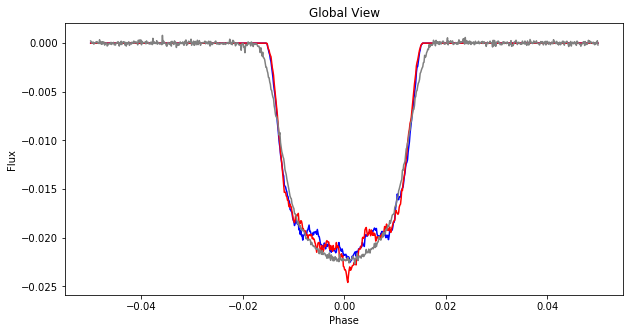

In [79]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(10,5))
#print(lc.shape, ph.shape)
kernel = np.ones(30)/30
plt.plot(np.array(ph)*0.5/np.pi,np.array(lc)-1, color='blue', label='3d')
plt.plot(np.array(ph)*0.5/np.pi,np.array(lc2)-1, color='red', label='3d')
plt.plot(np.array(ph)*0.5/np.pi,nflux, color='gray', label='data')
#plt.plot(np.array(df['phase']),np.convolve(np.array(df['flux']), kernel,mode='same'),color='gray')
#plt.plot(np.array(df['phase']), exp2, color='black', label='fit LD old')
#plt.plot(np.array(ph)/np.pi,np.array(lc2)-1, color='blue', label='2d')
# plt.plot(np.array(ph)/np.pi+0.5,np.array(lc3)-1, color='blue', label='3d')
plt.title('Global View')
plt.xlabel('Phase')
plt.ylabel('Flux')
#plt.xlim(-0.1,+0.1)
#plt.ylim(-0.2,.2)
#plt.savefig('not_a_fit.png')

0.0007480993680043825 0.0008136113695446373


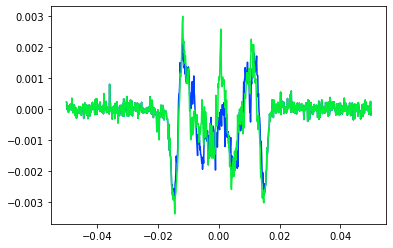

In [80]:
plt.plot(ph*0.5/np.pi,nflux-lc+1)
plt.plot(ph*0.5/np.pi,nflux-lc2+1)
print(np.std(nflux-lc+1), np.std(nflux-lc2+1))